In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['solution_stg1_release.csv', 'sample_submission_stg2.csv', 'train', 'additional_Type_2_v2', 'sample_submission.csv', 'test_stg2.7z', 'additional_Type_1_v2', 'fixed_labels_v2.csv', 'test_stg2_7z_password.txt', 'removed_files.csv', 'test', 'additional_Type_3_v2']


In [2]:
print(os.listdir("../input/train"))

['train']


In [3]:
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import Counter

import cv2
from concurrent import futures
import threading

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import datetime

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
#getting the total number of images in the training set

base_dir = os.path.join('../input/train/train')
type1_dir = os.path.join(base_dir,'Type_1')
type2_dir = os.path.join(base_dir,'Type_2')
type3_dir = os.path.join(base_dir,'Type_3')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

len(type1_files),len(type2_files),len(type3_files)

(250, 781, 450)

In [5]:
#Building a dataframe mapping images and Cancer type
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,../input/train/train/Type_1/710.jpg,Type_1
1,../input/train/train/Type_2/389.jpg,Type_2
2,../input/train/train/Type_2/883.jpg,Type_2
3,../input/train/train/Type_2/871.jpg,Type_2
4,../input/train/train/Type_3/1166.jpg,Type_3


In [6]:
#split training,dev and test set : 60:10:30

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(932,) (104,) (445,)
Train: Counter({'Type_2': 494, 'Type_3': 285, 'Type_1': 153}) 
Val: Counter({'Type_2': 61, 'Type_3': 27, 'Type_1': 16}) 
Test: Counter({'Type_2': 226, 'Type_3': 138, 'Type_1': 81})


In [7]:
#getting the summary of the dataset dimensions
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))


Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_7: working on img num: 931
Min Dimensions: [640 480   3]
Avg Dimensions: [3.67531330e+03 2.78401288e+03 3.00000000e+00]
Median Dimensions: [3.264e+03 3.096e+03 3.000e+00]
Max Dimensions: [4160 4128    3]


In [8]:

IMG_DIMS = (224, 224)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_9: working on img num: 931

Loading Validation Images:
ThreadPoolExecutor-1_9: working on img num: 0
ThreadPoolExecutor-1_4: working on img num: 103

Loading Test Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_8: working on img num: 444


((932, 224, 224, 3), (104, 224, 224, 3), (445, 224, 224, 3))

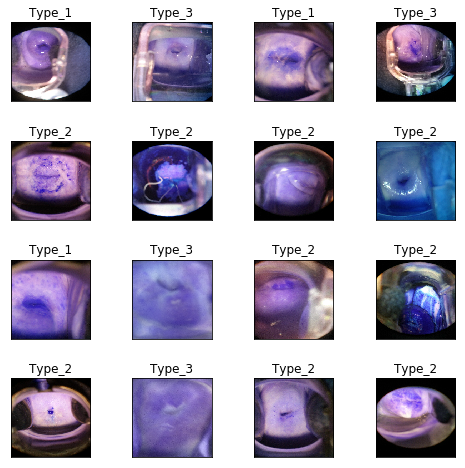

In [9]:
#viewing some sample images
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [10]:
#encode text categories with labels
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 20
INPUT_SHAPE = (224, 224, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = to_categorical(train_labels_enc, num_classes=3)
val_labels_1hotenc = to_categorical(val_labels_enc, num_classes=3)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])


['Type_2' 'Type_3' 'Type_1' 'Type_1' 'Type_2' 'Type_1'] [1 2 0 0 1 0]
['Type_2' 'Type_3' 'Type_1' 'Type_1' 'Type_2' 'Type_1'] [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [11]:
#using VGG19 pre-trained model
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(3, activation='softmax')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()


80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [12]:
history = model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose = 1)
                   

Train on 932 samples, validate on 104 samples
Epoch 1/20
932/932 [==============================] - 10s 10ms/sample - loss: 1.4622 - acc: 0.4367 - val_loss: 0.9770 - val_acc: 0.5865
Epoch 2/20
932/932 [==============================] - 3s 4ms/sample - loss: 1.0743 - acc: 0.4828 - val_loss: 1.0119 - val_acc: 0.4327
Epoch 3/20
932/932 [==============================] - 3s 4ms/sample - loss: 1.0072 - acc: 0.5139 - val_loss: 0.9390 - val_acc: 0.5962
Epoch 4/20
932/932 [==============================] - 3s 4ms/sample - loss: 0.9558 - acc: 0.5547 - val_loss: 0.9927 - val_acc: 0.5865
Epoch 5/20
932/932 [==============================] - 3s 4ms/sample - loss: 0.9359 - acc: 0.5526 - val_loss: 1.0055 - val_acc: 0.4231
Epoch 6/20
932/932 [==============================] - 3s 4ms/sample - loss: 0.9413 - acc: 0.5601 - val_loss: 0.9972 - val_acc: 0.5865
Epoch 7/20
932/932 [==============================] - 3s 4ms/sample - loss: 0.9293 - acc: 0.5408 - val_loss: 0.9898 - val_acc: 0.4615
Epoch 8/20
932

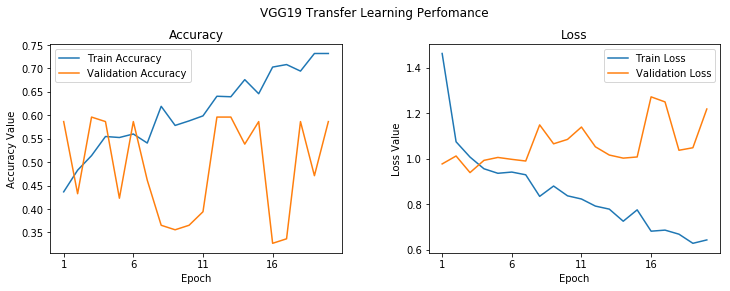

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG19 Transfer Learning Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [14]:
#print(history.history.keys())

In [15]:
#scaling the test set and one-hot encoding the test labels
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

le = LabelEncoder()
le.fit(test_labels)
test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = to_categorical(test_labels_enc, num_classes=3)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

['Type_2' 'Type_1' 'Type_2' 'Type_3' 'Type_1' 'Type_3'] [1 0 1 2 0 2]
['Type_2' 'Type_1' 'Type_2' 'Type_3' 'Type_1' 'Type_3'] [[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [16]:
model.evaluate(test_imgs_scaled,test_labels_1hotenc)

445/445 [==============================] - 3s 6ms/sample - loss: 1.3586 - acc: 0.5169


[1.3585577611173136, 0.5168539]